#### Import modules

In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import os

#### Extract features and save them

In [2]:
class FeatureExtractor:
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

fe = FeatureExtractor()

# Iterate through images (Change the path based on your image location)
for img_path in tqdm(os.listdir("../../data/samples/")):
    # Extract Features
    feature = fe.extract(img=Image.open('../../data/samples/' + str(img_path)))
    # Save the Numpy array (.npy) on designated path
    feature_path = "features/{}.npy".format(str(img_path).replace('.jpg','').replace('.JPG', ''))
    np.save(feature_path, feature)

#### Create features DataFrame

In [7]:
features = []
for f in tqdm(os.listdir("features/")):
  add_feature = np.load("features/" + str(f))
  add_feature = pd.DataFrame([add_feature])
  add_feature['image'] = f.replace('.npy','.jpg')

  features.append(add_feature)

features = pd.concat(features, axis=0)
features.to_csv('feature_extraction.csv', index=False)

  0%|          | 0/3673 [00:00<?, ?it/s]

#### Function for executing feature comparison model

In [7]:
def execute_feature_comparison(input_img_name, num_res):
    # Insert the image query
    img = Image.open(f"./img_tests/{input_img_name}")
    plt.imshow(Image.open('./img_tests/' + input_img_name))
    # Extract its features
    query = fe.extract(img)
    # Calculate the similarity (distance) between images
    features_data = features.copy()
    features_data = features_data.drop(columns = ['image'])
    features_data = features_data.values
    dists = np.linalg.norm(features_data - query, axis=1)

    # Extract 30 images that have lowest distance
    ids = np.argsort(dists)[:num_res]
    lookalike_imgs = features.iloc[ids,:]['image']
    scores = pd.DataFrame({'image': lookalike_imgs,
                        'score': dists[ids]})
    scores = scores.reset_index(drop=True)

    # Visualize the result
    axes=[]
    fig=plt.figure(figsize=(8,8))
    for a in range(num_res):
    
        if scores['image'][a].split('.')[0].split('_')[0] != input_img_name.split('.')[0].split('_')[0]:
            score = scores['score'][a]
            axes.append(fig.add_subplot(5, 6, a+1))
            subplot_title=str(scores['image'][a])
            axes[-1].set_title(subplot_title)  
            plt.axis('off')
            plt.imshow(Image.open('../../data/samples/' + scores['image'][a]))
    fig.tight_layout()
    plt.show()


----

### Para caso o modelo já esteja pronto:

In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import os

In [2]:
class FeatureExtractor:
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

fe = FeatureExtractor()

In [3]:
def get_name(file):
    ''' Get SKU from sample's file name'''
    
    if file.split('_')[0] == '':

        file = file.split('_')[2]
        file = file.split('-')[0]
    else:
        file = file.split('_')[0]
        file = file.split(' ')[0]
        file = file.split('.')[0] 
    file = file.split(' ')[0]
    return file.split('.')[0]

In [4]:
def execute_feature_comparison(input_img_name, num_res):
    # Insert the image query
    img = Image.open(f"./img_tests/{input_img_name}")
    plt.imshow(Image.open('./img_tests/' + input_img_name))
    # Extract its features
    query = fe.extract(img)

    # Filter input img identicalSKUs 
    features = pd.read_csv('feature_extraction.csv')
    features["sku"] = np.nan
    for idx, row in features.iterrows():
        features.loc[idx, 'sku'] = get_name(row['image'])

    features = features[features['sku'] != get_name(input_img_name)]
    

    # Calculate the similarity (distance) between images
    features_data = features.copy()
    features_data = features_data.drop(columns = ['image', 'sku'])
    features_data = features_data.values
    dists = np.linalg.norm(features_data - query, axis=1)
    print(query)

    # Extract 30 images that have lowest distance
    ids = np.argsort(dists)[:num_res]
    lookalike_imgs = features.iloc[ids,:]['image']
    scores = pd.DataFrame({'image': lookalike_imgs,
                        'score': dists[ids]})
    scores = scores.reset_index(drop=True)

    # Visualize the result
    axes=[]
    fig=plt.figure(figsize=(8,8))
    for a in range(num_res):
        score = scores['score'][a]
        axes.append(fig.add_subplot(5, 6, a+1))
        subplot_title=str(scores['image'][a])
        axes[-1].set_title(subplot_title)  
        plt.axis('off')
        plt.imshow(Image.open('../../data/samples/' + scores['image'][a]))
    fig.tight_layout()
    plt.show()


In [10]:
def execute_feature_comparison_samples(input_img_name, num_res):
    # Insert the image query
    img = Image.open(f"../../data/samples/{input_img_name}")
    plt.imshow(Image.open('../../data/samples/' + input_img_name))
    # Extract its features
    query = fe.extract(img)

    # Filter input img identicalSKUs 
    features = pd.read_csv('feature_extraction.csv')
    features["sku"] = np.nan
    for idx, row in features.iterrows():
        features.loc[idx, 'sku'] = get_name(row['image'])

    features = features[features['sku'] != get_name(input_img_name)]
    

    # Calculate the similarity (distance) between images
    features_data = features.copy()
    features_data = features_data.drop(columns = ['image', 'sku'])
    features_data = features_data.values
    dists = np.linalg.norm(features_data - query, axis=1)
    print(query)

    # Extract 30 images that have lowest distance
    ids = np.argsort(dists)[:num_res]
    lookalike_imgs = features.iloc[ids,:]['image']
    scores = pd.DataFrame({'image': lookalike_imgs,
                        'score': dists[ids]})
    scores = scores.reset_index(drop=True)

    # Visualize the result
    axes=[]
    fig=plt.figure(figsize=(8,8))
    for a in range(num_res):
        score = scores['score'][a]
        axes.append(fig.add_subplot(5, 4, a+1))
        subplot_title=str(scores['image'][a])
        axes[-1].set_title(subplot_title)  
        plt.axis('off')
        plt.imshow(Image.open('../../data/samples/' + scores['image'][a]))
    fig.tight_layout()
    plt.show()


#### Execute feature comparison model

*Colocar a imagem a ser usada de input no local:* <br>
C:\Users\fernanda.shinoda\Desktop\Projetos\Arezzo\POC_design_mapping\Main\notebooks\feature_comp\img_tests

1/1 [==============================] - 1s 715ms/step
[0.07267969 0.         0.         ... 0.01399036 0.         0.00035442]


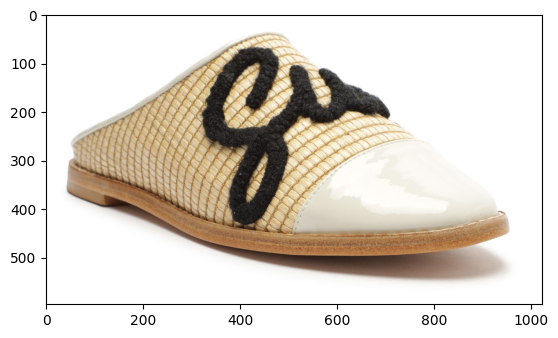

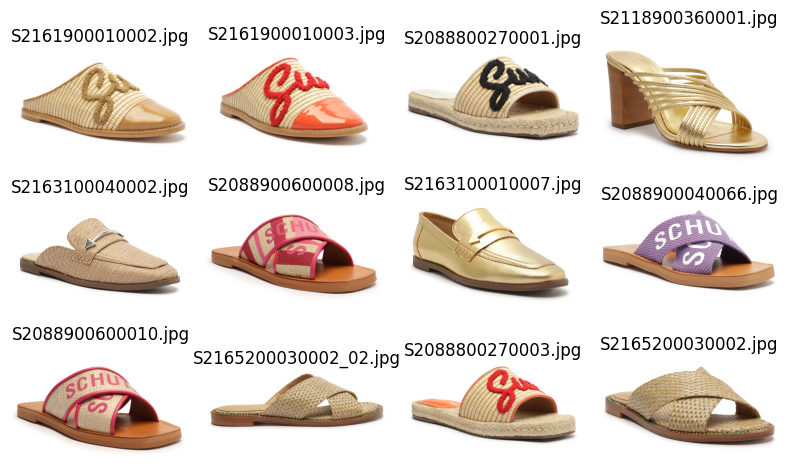

In [51]:
execute_feature_comparison_samples(input_img_name='S2161900010001.jpg', num_res=12)

In [ ]:
execute_feature_comparison(input_img_name='S0183000910002_02.jpg', num_res=10)